## Detroit Census Appeal Work
### Finding correlations between datasets in Detroit
- created: 11-22-21 by GTP
- notes: we want to find correlations between census data, steve's survey, voter registration data, etc
- see https://docs.google.com/document/d/1sp19lFNQ63NEvL43jJZsgzTasI31M6Fnw7XSgrcG9h0/edit for additional notes
- see https://drive.google.com/drive/folders/1UZmf4j9Pi7P7K_R3NMBjPMTzRbUNM-rV for data

In [2]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numbers
import decimal
#import data science packages
import scipy
import scipy.stats as stats

np.random.seed(222)
%matplotlib inline

In [3]:
#import geographic analysis libraries
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely as shp
from shapely.geometry import Point
from shapely.geometry import shape
import os
import re
from fiona.crs import from_epsg
import pysal as ps

In [4]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [5]:
#set crs for entire analysis
crs = {'init': 'epsg:4326'}

In [6]:
rf_param_grid = {'max_depth': [10, 20, 30], 'n_estimators': np.arange(401,602,100)}

In [7]:
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

## Read in Data

### Survey Done in 2020
- door knocking done by the city

In [8]:
survey_df = pd.read_csv('../data/All Doors FINAL Redacted 11-1-21.csv')

/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,3,4,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
len(survey_df[survey_df['TRACTCE10'].isna()])

19106

In [10]:
len(survey_df[survey_df['TRACTCE10'].isna()])/len(survey_df)

0.057172610052636144

In [11]:
def convert_tractce(tract_number):
    try:
        return str(int(tract_number))
    except:
        return "tract number n/a"

In [12]:
survey_df['TRACTCE10'] = survey_df['TRACTCE10'].apply(convert_tractce)

In [13]:
def get_survey_tract(census_tract):
    try:
        return str(int(census_tract))
    except:
        return ""

In [14]:
def get_census_tract(census_tract_og):
    x = str(census_tract_og)
    return x[-6:-2]

In [15]:
survey_df['tract'] = survey_df['CENSUS TRACT'].apply(get_survey_tract)

In [16]:
### filter out missing tracts
survey_df = survey_df[survey_df['tract']!=""]

In [17]:
len(survey_df)

315075

In [18]:
survey_df['vacant_dummy'] = survey_df['Occupancy Status:'].apply(lambda x: 1 if x == "vacant" else 0)
survey_df['occupied_dummy'] = survey_df['Occupancy Status:'].apply(lambda x: 1 if x == "occupied" else 0)

In [19]:
survey_df_by_census = survey_df.groupby(['tract'], as_index=False)['vacant_dummy', 'occupied_dummy'].mean()

<ipython-input-19-6dfe7bbbd5cd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  survey_df_by_census = survey_df.groupby(['tract'], as_index=False)['vacant_dummy', 'occupied_dummy'].mean()


In [20]:
survey_df_count_by_ct = survey_df.groupby(['tract'], as_index=False)['addr_id'].count()

In [21]:
survey_df_count_by_ct.columns = ['tract', 'survey_count']

### Census response rate

In [22]:
census_response_df = pd.read_csv('../data/2020 Census Response Rate by Tract (2).xlsx - decennialrr2020 (1).csv')

In [23]:
census_response_df.head(5)

,Tract,Internet Self Response,Total Self Response
0,500100,37.5,61.6
1,500200,38.9,66.6
2,500300,26.7,42.4
3,500400,11.2,20.4
4,500500,23.3,38.1


In [24]:
census_response_df['tract'] = census_response_df['Tract'].apply(lambda x: str(x)[0:4])

In [25]:
census_response_df.head()

,Tract,Internet Self Response,Total Self Response,tract
0,500100,37.5,61.6,5001
1,500200,38.9,66.6,5002
2,500300,26.7,42.4,5003
3,500400,11.2,20.4,5004
4,500500,23.3,38.1,5005


In [26]:
census_response_df = census_response_df[['tract', 'Internet Self Response', 'Total Self Response']]
census_response_df.columns = ['tract', 'internet_response_census', 'total_self_response_census']

## Vax status
- these census numbers are from 2019 ACS - Steve will give updated data that is 2020 census
- these are using CT10s - I would love to see something that has CT20s

In [27]:
vax_nov2021_df = pd.read_excel('../data/Vaccine Coverage by Census Tract as of 11.30.2021.xlsx')

In [28]:
vax_nov2021_df['tract'] = vax_nov2021_df['Census Tract'].apply(get_census_tract)

In [29]:
vax_nov2021_df_small = vax_nov2021_df[['tract', 'SVI', '% Received 1 or More Dose (Ages: 16+)', '% Fully Vaccinated (Ages: 16+)',\
                                       '% Received 1 or More Dose (Ages:5+)', '% Fully Vaccinated (Ages:5+)']]

In [30]:
vax_nov2021_df_small.columns = ['tract', 'SVI', 'pct_1_or_more_dose_16', 'pct_full_vaxed_16', 'pct_1_or_more_dose_5', 'pct_full_faxed_5']

## Voter Files
- need to merge on census tract to this...?

In [31]:
def get_census_tract_from_block(census_tract_og):
    x = str(census_tract_og)
    return x[0:4]

In [32]:
voter_nov_2020_df = pd.read_excel('../data/November 2020 General List of Voters.xlsx')

In [33]:
voter_nov_2020_gdf = gpd.read_file('../data/Voter Data/Nov20.shp')

In [34]:
voter_nov_2020_gdf['tract'] = voter_nov_2020_gdf['TRACTCE20'].apply(get_census_tract)

In [35]:
voters_by_tract = voter_nov_2020_gdf.groupby(['tract'], as_index=False)['Join_Count'].count()

In [36]:
voters_by_tract.columns = ['tract', 'voters_in_nov2020']

## Census Data
- I want to look at population / income / % black...?
- source: https://data.census.gov/cedsci/

### Population 2010
- source: https://data.census.gov/cedsci/all?g=0500000US26163%241400000&y=2010&d=DEC%20Summary%20File%201

In [37]:
pop_2010_df = pd.read_csv('../data/DECENNIALSF12010.P1_data_with_overlays_2021-12-05T220113.csv', skiprows=1)

In [38]:
pop_2010_df['tract'] = pop_2010_df['id'].apply(get_census_tract)

In [39]:
def clean_pop_total(x):
    pop_wout_parens = x.split('(')[0]
    return pop_wout_parens

In [40]:
pop_2010_df['Total'] = pop_2010_df['Total'].apply(clean_pop_total)

In [41]:
pop_2010_df_final = pop_2010_df[['tract', 'Total']]
pop_2010_df_final.columns = ['tract', 'tot_pop_2010']

In [42]:
pop_2010_df_final[pop_2010_df_final['tract']=='5430']

,tract,tot_pop_2010
259,5430,1814


### Income / Housing Units
- source: https://data.census.gov/cedsci/all?g=0500000US26163%241400000&y=2010&d=DEC%20Summary%20File%201
- table S1902

In [43]:
income_2019_df = pd.read_csv('../data/ACSST5Y2019.S1902_data_with_overlays_2021-12-05T222015.csv', skiprows=1)

In [44]:
income_2019_df = income_2019_df[['id', 'Estimate!!Number!!HOUSEHOLD INCOME!!All households', 'Estimate!!Mean income (dollars)!!HOUSEHOLD INCOME!!All households']]

In [45]:
income_2019_df['tract'] = income_2019_df['id'].apply(get_census_tract)

In [46]:
income_2019_df = income_2019_df[['tract', 'Estimate!!Number!!HOUSEHOLD INCOME!!All households', 'Estimate!!Mean income (dollars)!!HOUSEHOLD INCOME!!All households']]
income_2019_df.columns = ['tract', 'count_hh_2019', 'mean_hh_income_2019']

In [47]:
income_2019_df[income_2019_df['tract']=='5056']

,tract,count_hh_2019,mean_hh_income_2019


### Citizenship Status - 2019
- source: https://data.census.gov/cedsci/table?q=Citizenship&g=0500000US26163%241400000&y=2019&tid=ACSDT5Y2019.B05001&loc=42.2400,-83.1769,z10.0777
- table B05003
- needed for the denominator of # of people who voted in november 2020

In [48]:
citizen_2019_df = pd.read_csv('../data/ACSDT5Y2019.B05003_2022-01-25T195654/ACSDT5Y2019.B05003_data_with_overlays_2022-01-25T195636.csv', skiprows=1)

In [49]:
citizen_2019_df = citizen_2019_df[['Estimate!!Total:!!Male:!!18 years and over:',\
                                   'Estimate!!Total:!!Female:!!18 years and over:', \
                                   'Estimate!!Total:!!Male:!!18 years and over:!!Foreign born:!!Not a U.S. citizen', \
                                   'Estimate!!Total:!!Female:!!18 years and over:!!Foreign born:!!Not a U.S. citizen', 'id']]
citizen_2019_df.columns = ['male_pop_over18_2019', 'female_pop_over18_2019', 'male_pop_over18_nocitizen_2019', 'female_pop_over18_nocitizen_2019','id']

In [50]:
citizen_2019_df['over_18'] = citizen_2019_df['male_pop_over18_2019'] + citizen_2019_df['female_pop_over18_2019']
citizen_2019_df['citizen_over_18'] = citizen_2019_df['over_18'] - citizen_2019_df['male_pop_over18_nocitizen_2019'] - citizen_2019_df['female_pop_over18_nocitizen_2019']
citizen_2019_df['pct_citizen_over_18'] = citizen_2019_df['citizen_over_18'] / citizen_2019_df['over_18']

In [51]:
citizen_2019_df['tract'] = citizen_2019_df['id'].apply(get_census_tract)

In [52]:
citizen_2019_df_final = citizen_2019_df[['tract', 'citizen_over_18', 'pct_citizen_over_18']]

In [53]:
citizen_2019_df_final[citizen_2019_df_final['tract']=='5056']

,tract,citizen_over_18,pct_citizen_over_18


### population 2020 / % black / % white
- source: https://data.census.gov/cedsci/table?q=percent%20black&g=0500000US26163%241400000&y=2019&d=ACS%205-Year%20Estimates%20Data%20Profiles
- table DP05 - 2019 ACS

In [54]:
pop_df = pd.read_csv('../data/DECENNIALPL2020.P1_data_with_overlays_2021-12-08T181156.csv', skiprows=1)

In [55]:
pop_df = pop_df[['id', ' !!Total:', ' !!Total:!!Population of one race:!!White alone',\
                  ' !!Total:!!Population of one race:!!Black or African American alone']]

In [56]:
pop_df.columns = ['id', 'tot_pop_2020', 'tot_white', 'tot_black']

In [57]:
pop_df['pct_white'] = pop_df['tot_white'] / pop_df['tot_pop_2020']
pop_df['pct_black'] = pop_df['tot_black'] / pop_df['tot_pop_2020']

In [58]:
pop_df['tract'] = pop_df['id'].apply(get_census_tract)

In [59]:
pop_df_final = pop_df[['tract', 'tot_pop_2020', 'pct_white', 'pct_black']]

In [60]:
pop_df_final[pop_df_final['tract']=='5056']

,tract,tot_pop_2020,pct_white,pct_black
37,5056,4078,0.023786,0.928396


## Age 2019 ACS
- source: https://data.census.gov/cedsci/table?q=Age%20and%20Sex&t=Population%20Total%3APopulations%20and%20People&g=0500000US26163%241400000&tid=ACSST5Y2019.S0101
- table S0101
- I want to add <18 pop to analysis and >65 pop to analysis
- Incorporated <18 pop into regression, run regression - specifically i want to look at <18 pop to see CTC (child tax credit) outreach

In [61]:
age_df = pd.read_csv('../data/ACSST5Y2019.S0101_2022-02-08T213209/ACSST5Y2019.S0101_data_with_overlays_2022-02-08T213200.csv', skiprows=1)

In [63]:
age_df = age_df[['id', 'Estimate!!Total!!Total population', 'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years', \
                 'Estimate!!Percent!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years',\
                 'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over',\
                  'Estimate!!Percent!!Total population!!SELECTED AGE CATEGORIES!!65 years and over']]
age_df.columns = ['id', 'pop_2019', 'pop_lt_18', 'pct_lt_18', 'pop_gt_65', 'pct_gt_65']
age_df['tract'] = age_df['id'].apply(get_census_tract)

In [64]:
age_df.head()

,id,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65,tract
0,1400000US26163500100,3369,776,23.0,269,8.0,5001
1,1400000US26163500200,2834,731,25.8,244,8.6,5002
2,1400000US26163500300,1900,483,25.4,59,3.1,5003
3,1400000US26163500400,1052,247,23.5,54,5.1,5004
4,1400000US26163500500,1289,286,22.2,97,7.5,5005


In [65]:
age_df_final = age_df[['tract', 'pop_2019', 'pop_lt_18', 'pct_lt_18', 'pop_gt_65', 'pct_gt_65']]

In [66]:
age_df_final[age_df_final['tract']=='5056']

,tract,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65


## merge together 2010 census files

In [68]:
tract_df_2010_total = vax_nov2021_df_small.merge(survey_df_by_census, how='left')
tract_df_2010_total = tract_df_2010_total.merge(income_2019_df, how='left')
tract_df_2010_total = tract_df_2010_total.merge(survey_df_count_by_ct, how='left')
tract_df_2010_total = tract_df_2010_total.merge(survey_df_by_census, how='left')
tract_df_2010_total = tract_df_2010_total.merge(citizen_2019_df_final, how='left')
tract_df_2010_total = tract_df_2010_total.merge(age_df_final, how='left')

In [69]:
### convert to numerics
tract_df_2010_total['mean_hh_income_2019'] = pd.to_numeric(tract_df_2010_total['mean_hh_income_2019'], errors='coerce')
tract_df_2010_total['mean_hh_income_2019'] = tract_df_2010_total['mean_hh_income_2019'].fillna(0)
tract_df_2010_total['pop_lt_18'] = pd.to_numeric(tract_df_2010_total['pop_lt_18'], errors='coerce')
tract_df_2010_total['pop_lt_18'] = tract_df_2010_total['pop_lt_18'].fillna(0)
tract_df_2010_total['pct_lt_18'] = pd.to_numeric(tract_df_2010_total['pct_lt_18'], errors='coerce')
tract_df_2010_total['pct_lt_18'] = tract_df_2010_total['pct_lt_18'].fillna(0)
tract_df_2010_total['pop_gt_65'] = pd.to_numeric(tract_df_2010_total['pop_gt_65'], errors='coerce')
tract_df_2010_total['pop_gt_65'] = tract_df_2010_total['pop_gt_65'].fillna(0)
tract_df_2010_total['pct_gt_65'] = pd.to_numeric(tract_df_2010_total['pct_gt_65'], errors='coerce')
tract_df_2010_total['pct_gt_65'] = tract_df_2010_total['pct_gt_65'].fillna(0)

In [70]:
### remove tracts 9852 and 9855 - these ones are outliers it seems, only pop counts of 0 and 3 exist for them
### 9852 is the tract on the eastside with the GM conner plant that is empty in the final map
### 9859 is the tract along russell on the SE corner of 75 and 94
### 9842 & 9836 are the 2 tracts that are railroad yards south of john kronk in SW detroit
tract_df_2010_total = tract_df_2010_total[~tract_df_2010_total['tract'].isin(['9850', '9852', '9855', '9859'])]

In [71]:
tract_df_2010_total['pct_full_vaxed_16'][tract_df_2010_total['pct_full_vaxed_16']=='>100%'] = 1
tract_df_2010_total['pct_1_or_more_dose_16'][tract_df_2010_total['pct_1_or_more_dose_16']=='>100%'] = 1
tract_df_2010_total['pct_1_or_more_dose_5'][tract_df_2010_total['pct_1_or_more_dose_5']=='>100%'] = 1
tract_df_2010_total['pct_full_faxed_5'][tract_df_2010_total['pct_full_faxed_5']=='>100%'] = 1

In [72]:
tract_df_2010_total.head()

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
0,5001,0.5912,0.448,0.386,0.369,0.317,0.065629,0.897835,1438,49015.0,1478.0,2593,1.000000,3369,776,23.0,269,8.0
1,5002,0.4878,0.441,0.374,0.342,0.29,NaN,NaN,1088,61980.0,NaN,2094,0.995720,2834,731,25.8,244,8.6
2,5003,0.8413,0.411,0.346,0.324,0.272,0.323144,0.660480,811,50345.0,916.0,1417,1.000000,1900,483,25.4,59,3.1
3,5004,0.8786,0.294,0.248,0.23,0.193,1.000000,0.000000,375,34880.0,6.0,803,0.997516,1052,247,23.5,54,5.1
4,5005,0.6355,0.364,0.31,0.308,0.26,0.370460,0.607748,506,43058.0,826.0,998,0.995015,1289,286,22.2,97,7.5


In [73]:
tract_df_2010_total[tract_df_2010_total['tract']=='5104']

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
59,5104,0.7346,0.499,0.424,0.468,0.397,0.457286,0.542714,260,30150.0,597.0,417,1.0,514,97,18.9,106,20.6


In [74]:
tract_df_2010_total[tract_df_2010_total['tract']=='5105']

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
60,5105,0.9225,0.793,0.709,0.69,0.619,0.017744,0.968314,1164,39426.0,789.0,1707,0.536624,4257,1076,25.3,366,8.6


## Try to predict vacant % / occupied %
- 7% of tracts didn't have a number for some reason
- we need to fill in data where pct vacant is missing or zero.

Strategy:
- build a ML model to predict pct vacant based on SVI, count_hh_2019, mean_hh_income_2019, pct_full_vaxed_16: then take that model to then predict on original data

## Clean up data
- we've got some nans

In [75]:
len(tract_df_2010_total[tract_df_2010_total['vacant_dummy'].isna()]) / len(tract_df_2010_total)

0.06484641638225255

In [76]:
vacant_dummy_df = tract_df_2010_total[['SVI', 'count_hh_2019', 'mean_hh_income_2019', 'pct_full_vaxed_16', 'vacant_dummy']]

In [77]:
#drop rows where vacant_dummy is NaN
vacant_dummy_df = vacant_dummy_df[np.isfinite(vacant_dummy_df['vacant_dummy'])]

In [78]:
X = vacant_dummy_df.drop(['vacant_dummy'], axis=1)
y = vacant_dummy_df['vacant_dummy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# use random forest to predict vacant_dummy
r_tree = RandomForestRegressor()
r_tree_tuned_vacant = GridSearchCV(r_tree, rf_param_grid)
r_tree_tuned_vacant.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': array([401, 501, 601])})

In [80]:
#explore feature importance
feature_importance = r_tree_tuned_vacant.best_estimator_.fit(X_train, y_train).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)
Feature_importance_df

,variables,importance
0,count_hh_2019,0.456591
1,SVI,0.228642
2,pct_full_vaxed_16,0.170896
3,mean_hh_income_2019,0.143871


In [81]:
#run accuracy metrics
predictions = r_tree_tuned_vacant.predict(X_test)
#RMSE
mean_squared_error(y_test, predictions)**0.5

0.1648156551362912

In [82]:
y_test.std()

0.16809712415082523

In [83]:
#apply model to full data
vacant_dummy_predict = tract_df_2010_total[['SVI', 'count_hh_2019', 'mean_hh_income_2019', 'pct_full_vaxed_16']]

tract_df_2010_total['vacant_dummy_predict'] = r_tree_tuned_vacant.predict(vacant_dummy_predict)

#if missing vacant_dummy (or if it's zero), replace with predicted value
tract_df_2010_total['vacant_dummy'][(np.isnan(tract_df_2010_total['vacant_dummy']))]\
= tract_df_2010_total['vacant_dummy_predict']
        
#drop predicted vacant_dummy_predict
tract_df_2010_total = tract_df_2010_total.drop(['vacant_dummy_predict'], axis=1)

<ipython-input-83-f819fbe4649f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_df_2010_total['vacant_dummy'][(np.isnan(tract_df_2010_total['vacant_dummy']))]\


In [84]:
### fill in blank occupied_dummies with 1 - predicted vacant dummy
tract_df_2010_total['occupied_dummy'][tract_df_2010_total['occupied_dummy'].isna()] = 1 - tract_df_2010_total['vacant_dummy']

<ipython-input-84-091f31794f36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_df_2010_total['occupied_dummy'][tract_df_2010_total['occupied_dummy'].isna()] = 1 - tract_df_2010_total['vacant_dummy']


## merge together 2020 census files

In [85]:
tract_df_2020_total = census_response_df.merge(pop_df_final, how='left')
tract_df_2020_total = tract_df_2020_total.merge(voters_by_tract, how='left')
tract_df_2020_total = tract_df_2020_total.merge(census_response_df, how='left')

In [86]:
tract_df_2020_total['tot_pop_2020'] = pd.to_numeric(tract_df_2020_total['tot_pop_2020'], errors='coerce')
tract_df_2020_total['tot_pop_2020'] = tract_df_2020_total['tot_pop_2020'].fillna(0)
tract_df_2020_total['voters_in_nov2020'] = tract_df_2020_total['voters_in_nov2020'].fillna(0)
tract_df_2020_total['pct_black'] = tract_df_2020_total['pct_black'].fillna(0)
tract_df_2020_total['pct_white'] = tract_df_2020_total['pct_white'].fillna(0)
tract_df_2020_total['internet_response_census'] = tract_df_2020_total['internet_response_census'].fillna(0)
tract_df_2020_total['total_self_response_census'] = tract_df_2020_total['total_self_response_census'].fillna(0)

In [87]:
tract_df_2020_total.sample(10)

,tract,internet_response_census,total_self_response_census,tot_pop_2020,pct_white,pct_black,voters_in_nov2020
225,5413,43.0,64.7,2664,0.147898,0.794670,1027
232,5423,32.4,58.5,2255,0.018182,0.936142,948
127,5259,21.6,42.3,2610,0.204215,0.204981,525
152,5318,15.4,28.4,1500,0.016667,0.941333,579
106,5220,30.1,58.7,1789,0.035774,0.921744,682
218,5406,39.7,70.9,3274,0.021686,0.930666,1668
177,5357,27.5,50.1,1313,0.013709,0.918507,503
39,5058,25.3,42.4,3337,0.492358,0.432125,1042
230,5421,38.3,69.8,4547,0.011656,0.954036,2121
213,5401,35.8,64.8,3201,0.012184,0.948454,1483


## Need to merge 2010 census tracts to 2020 census tracts
### read in census tract shapefiles
- source: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html

In [88]:
ct_gdf = gpd.read_file('../data/tl_2020_26_tract20.shp')

In [89]:
ct_gdf['tract'] = ct_gdf['GEOID20'].apply(get_census_tract)

In [90]:
ct10_gdf = gpd.read_file('../data/tl_2020_26_tract10.shp')

In [91]:
ct10_gdf['tract'] = ct10_gdf['GEOID10'].apply(get_census_tract)

In [92]:
tract20_df_final_shp = ct_gdf.merge(tract_df_2020_total, how='left', on='tract')

In [93]:
tract20_df_final_shp.drop(columns=['STATEFP20', 'COUNTYFP20','TRACTCE20',\
                                 'GEOID20', 'NAME20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20',\
                                 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20'], inplace=True)

In [94]:
tract20_df_final_shp.to_file('../data/tract20_df_final_shp.shp')

In [95]:
tract10_df_final_shp = ct10_gdf.merge(tract_df_2010_total, how='left', on='tract')

In [96]:
tract10_df_final_shp.drop(columns=['STATEFP10', 'COUNTYFP10','TRACTCE10',\
                                 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10',\
                                 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10'], inplace=True)

In [97]:
tract10_df_final_shp.to_file('../data/tract10_df_final_shp.shp')

## Merge 2010 and 2020 shapefiles together
1. spatially merge using overlay function (returns areas of intersection)
2. (in keep_polys_and_explode) - only keep polygons that have a significant area - explode converts multipolygons to polygons (https://stackoverflow.com/questions/68861184/convert-geopandas-multipolygon-to-polygon) and only keep polygons (not geometry collections)
3. aggregate accordingly (income take average, etc)

In [112]:
tract_20_w_10_gdf_merged = gpd.overlay(tract20_df_final_shp, tract10_df_final_shp, how='union', make_valid=False, keep_geom_type=False)

In [113]:
tract_20_w_10_gdf_merged.head()

,tract_1,internet_response_census,total_self_response_census,tot_pop_2020,pct_white,pct_black,voters_in_nov2020,tract_2,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65,geometry
0,5919,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-83.24385 42.08143, -83.24375 42.081..."
1,5930,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.21551 42.11191, -83.2161..."
2,9820,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.24167 42.10964, -83.2416..."
3,5944,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-83.21440 42.11194)
4,5991,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.24185 42.09537, -83.2418..."


In [114]:
tract_20_w_10_gdf_merged['pct_full_vaxed_16'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_full_vaxed_16'], errors='coerce')
tract_20_w_10_gdf_merged['pct_1_or_more_dose_16'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_1_or_more_dose_16'], errors='coerce')
tract_20_w_10_gdf_merged['pct_1_or_more_dose_5'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_1_or_more_dose_5'], errors='coerce')
tract_20_w_10_gdf_merged['pct_full_faxed_5'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_full_faxed_5'], errors='coerce')
tract_20_w_10_gdf_merged['citizen_over_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['citizen_over_18'], errors='coerce')
tract_20_w_10_gdf_merged['pop_2019'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_2019'], errors='coerce')
tract_20_w_10_gdf_merged['pop_lt_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_lt_18'], errors='coerce')
tract_20_w_10_gdf_merged['pct_lt_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_lt_18'], errors='coerce')
tract_20_w_10_gdf_merged['pop_gt_65'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_gt_65'], errors='coerce')
tract_20_w_10_gdf_merged['pct_gt_65'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_gt_65'], errors='coerce')

In [120]:
def keep_polys_and_explode(gdf_in):
    gdf_in_copy = gdf_in.copy()
    print(gdf_in_copy.crs)
    gdf_in_copy = gdf_in_copy.to_crs({'init': 'epsg:3857'})
    print(gdf_in_copy.crs)
    gdf_in_copy["area_km2"] = gdf_in_copy['geometry'].area/ 10**6
    ### remove polygons that are tiny intersections (<0.1km2)
    gdf_in_copy = gdf_in_copy[gdf_in_copy['area_km2']>0.1]
    exploded=gdf_in_copy.explode()
    exploded.reset_index(inplace=True)
    exploded['type'] = exploded['geometry'].apply(lambda x: str(type(x)))
    exploded = exploded[exploded['type']=="<class 'shapely.geometry.polygon.Polygon'>"]
    exploded.drop(['level_0', 'level_1', 'type'], axis=1, inplace=True)
    return exploded

In [121]:
tract_20_w_10_gdf_exploded = keep_polys_and_explode(tract_20_w_10_gdf_merged)

epsg:4269


/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


+init=epsg:3857 +type=crs


In [134]:
tract_20_w_10_gdf_mean = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['internet_response_census', 'total_self_response_census',
                                                                                                     'pct_white', 'pct_black', \
                                                                                                     'SVI', 'pct_1_or_more_dose_16', 'pct_full_vaxed_16',\
                                                                                                     'pct_1_or_more_dose_5', 'pct_full_faxed_5', 'voters_in_nov2020', 'tot_pop_2020', \
                                                                                   'vacant_dummy', 'occupied_dummy',\
                                                                                  'mean_hh_income_2019'].mean()

<ipython-input-134-da33dd75bcef>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tract_20_w_10_gdf_mean = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['internet_response_census', 'total_self_response_census',


In [135]:
tract_20_w_10_gdf_sum = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['count_hh_2019', 'survey_count', 'citizen_over_18', 'pop_2019',\
                                                                                       'pop_lt_18', 'pop_gt_65'].sum()

<ipython-input-135-556e5845be44>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tract_20_w_10_gdf_sum = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['count_hh_2019', 'survey_count', 'citizen_over_18', 'pop_2019',\


In [136]:
tract_20_w_10_gdf_total_agg = tract_20_w_10_gdf_mean.merge(tract_20_w_10_gdf_sum)

In [137]:
tract_20_w_10_gdf_total_agg.rename(columns={"tract_1": "tract"}, inplace=True)

In [138]:
tract_20_w_10_gdf_shp = ct_gdf.merge(tract_20_w_10_gdf_total_agg, how='left', on='tract')

In [139]:
tract_20_w_10_gdf_shp.drop(columns=['STATEFP20', 'COUNTYFP20','TRACTCE20',\
                                 'GEOID20', 'NAME20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20',\
                                 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20'], inplace=True)

In [140]:
tract_20_w_10_gdf_shp_w_10_nans = tract_20_w_10_gdf_shp.merge(tract10_df_final_shp, how='left', suffixes=('', '_10'), on='tract')

In [141]:
tract_20_w_10_gdf_shp_w_10_nans[tract_20_w_10_gdf_shp_w_10_nans['tract']=='5091']

,geometry,tract,internet_response_census,total_self_response_census,pct_white,pct_black,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,voters_in_nov2020,tot_pop_2020,vacant_dummy,occupied_dummy,mean_hh_income_2019,count_hh_2019,survey_count,citizen_over_18,pop_2019,pop_lt_18,pop_gt_65,geometry_10,SVI_10,pct_1_or_more_dose_16_10,pct_full_vaxed_16_10,pct_1_or_more_dose_5_10,pct_full_faxed_5_10,vacant_dummy_10,occupied_dummy_10,count_hh_2019_10,mean_hh_income_2019_10,survey_count_10,citizen_over_18_10,pct_citizen_over_18,pop_2019_10,pop_lt_18_10,pct_lt_18,pop_gt_65_10,pct_gt_65
4982,"POLYGON ((-83.08942 42.41816, -83.08858 42.418...",5091,26.4,40.7,0.128205,0.217839,0.82855,0.646,0.5665,0.579,0.508,1366.0,4563.0,0.237515,0.755514,34788.0,1424.0,1386.0,2124.0,4771.0,1173.0,472.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5_10']
tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18'][tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18']==0] = tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18_10']
tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy'][tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy_10']
tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy'][tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy_10']
tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019'][tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019_10']
tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019'][tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019']==0] = tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019_10']
tract_20_w_10_gdf_shp_w_10_nans['survey_count'][tract_20_w_10_gdf_shp_w_10_nans['survey_count']==0] = tract_20_w_10_gdf_shp_w_10_nans['survey_count_10']
tract_20_w_10_gdf_shp_w_10_nans['pop_2019'][tract_20_w_10_gdf_shp_w_10_nans['pop_2019']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_2019']
tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18'][tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18']
tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65'][tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65']

<ipython-input-142-a2e77c8e47ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16_10']
<ipython-input-142-a2e77c8e47ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16_10']
<ipython-input-142-a2e77c8e47ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [143]:
### pct voted
tract_20_w_10_gdf_shp_w_10_nans['pct_voted_nov2020'] = tract_20_w_10_gdf_shp_w_10_nans['voters_in_nov2020'] / tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18']

In [443]:
tract_20_w_10_gdf_shp_w_10_nans['survey_count'] = tract_20_w_10_gdf_shp_w_10_nans['survey_count'].fillna(0)

In [144]:
tract_20_w_10_gdf_shp_w_10_nans['pct_lt_18'] = tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18'] / tract_20_w_10_gdf_shp_w_10_nans['pop_2019']
tract_20_w_10_gdf_shp_w_10_nans['pct_gt_65'] = tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65'] / tract_20_w_10_gdf_shp_w_10_nans['pop_2019']

In [145]:
tract_20_w_10_gdf_shp_w_10_nans.drop(['geometry_10', 
                                      'SVI_10', 'vacant_dummy_10', 'occupied_dummy_10',\
                                      'count_hh_2019_10', 'mean_hh_income_2019_10', 'survey_count_10',\
                                     'pct_citizen_over_18', 'citizen_over_18_10', 'pop_lt_18', 'pop_2019',\
                                     'pop_gt_65'], axis=1, inplace=True)

## Look at correlation matrix
- where did all of these come from...?

In [146]:
feature_list = ['tot_pop_2020',\
                     'SVI', 'pct_full_vaxed_16', 'pct_full_faxed_5',\
                     'vacant_dummy', 'occupied_dummy', 'count_hh_2019',\
                     'mean_hh_income_2019', 'internet_response_census', \
                     'total_self_response_census', 'survey_count', \
                'pct_white', 'pct_black', 'pct_voted_nov2020',\
               'citizen_over_18', 'pct_lt_18', 'pct_gt_65']

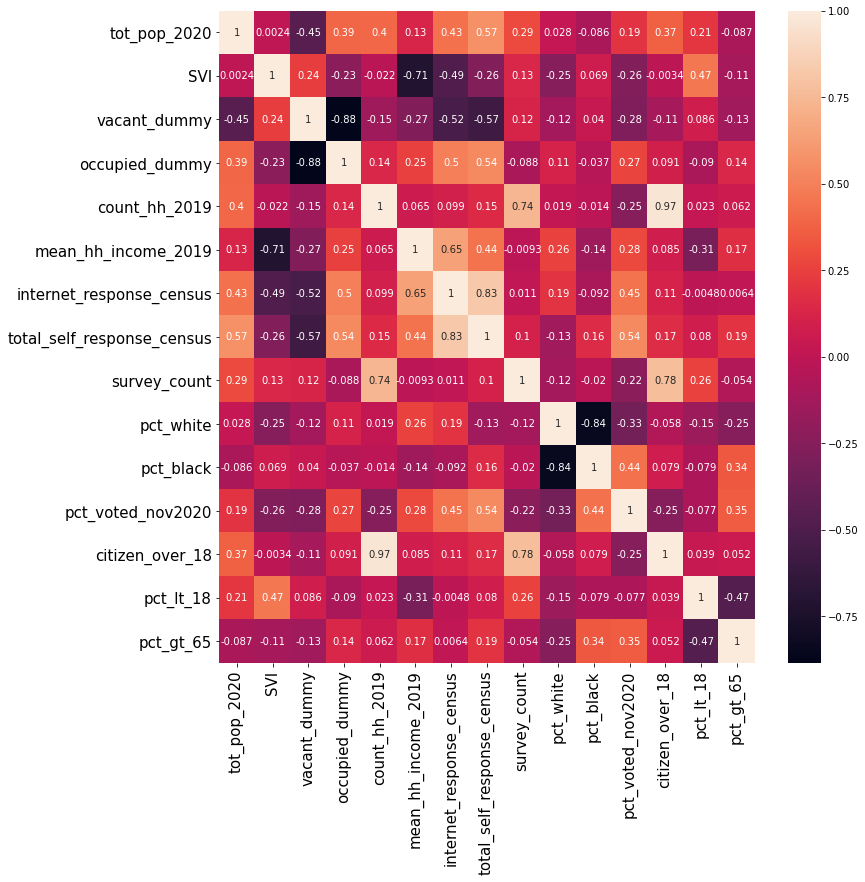

In [147]:
#output map
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


sns.heatmap(tract_20_w_10_gdf_shp_w_10_nans[feature_list].corr(), annot=True, ax=ax)

## Regression looking at pct_full_vaxed_5
https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

In [148]:
### essentially, subset to just detroit CTs
tract_20_w_10_gdf_shp_detroit = tract_20_w_10_gdf_shp_w_10_nans[tract_20_w_10_gdf_shp_w_10_nans['pct_black']>=0]
### remove nas
tract_20_w_10_gdf_shp_detroit = tract_20_w_10_gdf_shp_detroit[~tract_20_w_10_gdf_shp_detroit['SVI'].isna()]

In [149]:
len(tract_20_w_10_gdf_shp_detroit)

267

In [150]:
y = tract_20_w_10_gdf_shp_detroit.pct_full_faxed_5

In [151]:
regression_feature_list = set(feature_list) - set(['pct_full_vaxed_16', 'pct_full_faxed_5', 'pct_white', 'citizen_over_18'])
X = tract_20_w_10_gdf_shp_detroit[regression_feature_list]

In [155]:
regression_feature_list

{'SVI',
 'count_hh_2019',
 'internet_response_census',
 'mean_hh_income_2019',
 'occupied_dummy',
 'pct_black',
 'pct_gt_65',
 'pct_lt_18',
 'pct_voted_nov2020',
 'survey_count',
 'tot_pop_2020',
 'total_self_response_census',
 'vacant_dummy'}

In [166]:
# ### fit LOGIT regression to X and y (not x train and y train)
model = sm.Logit(y.astype(float), X).fit()
predictions = model.predict(X) # make the predictions by the model

# # Print out the statistics
model.summary()

MissingDataError: exog contains inf or nans

In [153]:
model.params.values

NameError: name 'model' is not defined

In [154]:
odds = np.exp(model.params.values)
odds

NameError: name 'model' is not defined

“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”

In [454]:
# ### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y.astype(float), X).fit()
predictions = model.predict(X) # make the predictions by the model

# # Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       pct_full_faxed_5   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              408.8
Date:                Tue, 25 Jan 2022   Prob (F-statistic):                   2.03e-155
Time:                        22:15:43   Log-Likelihood:                          287.40
No. Observations:                 267   AIC:                                     -552.8
Df Residuals:                     256   BIC:                                     -513.3
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
occupied_dummy                 0.2745      0.047      5.817      0.000       0.182       0.367
survey_count               -7.572e-06   6.85e-06     -1.105      0.270   -2.11e-05    5.92e-06
SVI                           -0.0319      0.038     -0.838      0.403      -0.107       0.043
tot_pop_2020               -2.038e-05      7e-06     -2.914      0.004   -3.42e-05   -6.61e-06
pct_black                     -0.1379      0.026     -5.221      0.000      -0.190      -0.086
internet_response_census      -0.0005      0.001     -0.487      0.627      -0.003       0.002
total_self_response_census    -0.0002      0.001     -0.219      0.826      -0.002       0.002
mean_hh_income_2019         2.019e-06   5.02e-07      4.021      0.000    1.03e-06    3.01e-06
vacant_dummy                   0.2041      0.055      3.683      0.000       0.095       0.313
pct_voted_nov2020              0.3673      0.054      6.851      0.000       0.262       0.473
count_hh_2019               3.574e-05    1.1e-05      3.252      0.001    1.41e-05    5.74e-05
==============================================================================
Omnibus:                      118.473   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.839
Skew:                           1.680   Prob(JB):                    4.01e-158
Kurtosis:                      10.339   Cond. No.                     6.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression looking at pct_voted_nov2020
https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

In [455]:
y = tract_20_w_10_gdf_shp_detroit.pct_voted_nov2020
regression_feature_list = set(feature_list) - set(['pct_voted_nov2020', 'citizen_over_18', 'pct_white', 'occupied_dummy', 'pct_full_vaxed_16'])
X = tract_20_w_10_gdf_shp_detroit[regression_feature_list]

In [459]:
regression_feature_list

{'SVI',
 'count_hh_2019',
 'internet_response_census',
 'mean_hh_income_2019',
 'pct_black',
 'pct_full_faxed_5',
 'survey_count',
 'tot_pop_2020',
 'total_self_response_census',
 'vacant_dummy'}

In [460]:
# # ### fit LOGIT regression to X and y (not x train and y train)
model = sm.Logit(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X.astype(float)) # make the predictions by the model

# # # Print out the statistics
model.summary()

Optimization terminated successfully.
         Current function value: 0.645498
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      pct_voted_nov2020   No. Observations:                  267
Model:                          Logit   Df Residuals:                      257
Method:                           MLE   Df Model:                            9
Date:                Tue, 25 Jan 2022   Pseudo R-squ.:                 0.06307
Time:                        22:16:20   Log-Likelihood:                -172.35
converged:                       True   LL-Null:                       -183.95
Covariance Type:            nonrobust   LLR p-value:                  0.005753
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
survey_count               -3.263e-05      0.000     -0.193      0.847      -0.000       0.000
SVI                           -1.2800      0.676     -1.892      0.058      -2.606       0.046
tot_pop_2020                   0.0003      0.000      1.429      0.153      -0.000       0.001
pct_black                      0.7363      0.571      1.290      0.197      -0.383       1.855
pct_full_faxed_5               1.0359      1.307      0.793      0.428      -1.525       3.597
internet_response_census      -0.0052      0.026     -0.197      0.844      -0.057       0.046
total_self_response_census     0.0143      0.022      0.638      0.523      -0.030       0.058
mean_hh_income_2019        -6.393e-06    1.2e-05     -0.535      0.593   -2.98e-05     1.7e-05
vacant_dummy                  -0.1702      1.038     -0.164      0.870      -2.204       1.864
count_hh_2019                 -0.0008      0.000     -2.065      0.039      -0.001   -3.85e-05
==============================================================================================
"""

In [462]:
# odds = np.exp(model.params.values)
odds

array([1.06402877, 0.99999331, 0.4411441 , 0.99990275, 0.48923574,
       0.99545065, 1.0009503 , 1.00000193, 0.6711817 , 4.19205813,
       1.00010647])

## "Civic Participation" Metric
- z(vax) + z(voter) + z(census) + z(pop)

In [463]:
# now iterate over the remaining columns and create a new zscore column
zscore_cols = ['pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020']
for col in zscore_cols:
    col_zscore = col + '_zscore'
    tract_20_w_10_gdf_shp_detroit[col_zscore] = \
    (tract_20_w_10_gdf_shp_detroit[col] - tract_20_w_10_gdf_shp_detroit[col].mean())/\
    tract_20_w_10_gdf_shp_detroit[col].std(ddof=0)

In [464]:
tract_20_w_10_gdf_shp_detroit_final = tract_20_w_10_gdf_shp_detroit[['geometry', 'tract', 'pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020',\
                                                                    'pct_full_faxed_5_zscore', 'pct_voted_nov2020_zscore', 'total_self_response_census_zscore', 'tot_pop_2020_zscore']]

In [465]:
tract_20_w_10_gdf_shp_detroit_final.columns = ['geometry', 'tract', 'pct_vax5', 'pct_vote', 'pct_census', 'population', 'pct_vax5_z', 'pct_vote_z', 'pct_census_z', 'population_z']

In [466]:
tract_20_w_10_gdf_shp_detroit_final.to_file('../data/tract_20_w_10_gdf_shp_detroit.shp')

## Regression predicting civic participation vs income / pop density / % black
- education?

In [482]:
tract_20_w_10_gdf_shp_detroit_copy = tract_20_w_10_gdf_shp_detroit.copy()
print(tract_20_w_10_gdf_shp_detroit_copy.crs)
tract_20_w_10_gdf_shp_detroit_copy= tract_20_w_10_gdf_shp_detroit_copy.to_crs({'init': 'epsg:3857'})
print(tract_20_w_10_gdf_shp_detroit_copy.crs)

epsg:4269


/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


+init=epsg:3857 +type=crs


In [483]:
tract_20_w_10_gdf_shp_detroit_copy["area_km2"] = tract_20_w_10_gdf_shp_detroit_copy['geometry'].area/ 10**6


In [484]:
tract_20_w_10_gdf_shp_detroit_copy['pop_density_2020'] = tract_20_w_10_gdf_shp_detroit_copy['tot_pop_2020'] / tract_20_w_10_gdf_shp_detroit_copy['area_km2']

In [485]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_score'] = tract_20_w_10_gdf_shp_detroit_copy['pct_full_faxed_5_zscore'] +\
                                                                  tract_20_w_10_gdf_shp_detroit_copy['pct_voted_nov2020_zscore'] +\
                                                                  tract_20_w_10_gdf_shp_detroit_copy['total_self_response_census_zscore']


In [486]:
### put together X and y for regression
y = tract_20_w_10_gdf_shp_detroit_copy.civic_participation_score
### get list of all new dummy columns and all other columns of interest
X_columns = ['pop_density_2020', 'mean_hh_income_2019', 'pct_black']
X = tract_20_w_10_gdf_shp_detroit_copy[X_columns]

### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     civic_participation_score   R-squared (uncentered):                   0.065
Model:                                   OLS   Adj. R-squared (uncentered):              0.055
Method:                        Least Squares   F-statistic:                              6.166
Date:                       Wed, 26 Jan 2022   Prob (F-statistic):                    0.000458
Time:                               19:20:15   Log-Likelihood:                         -577.06
No. Observations:                        267   AIC:                                      1160.
Df Residuals:                            264   BIC:                                      1171.
Df Model:                                  3                                                  
Covariance Type:                   nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
pop_density_2020     4.606e-05      0.000      0.222      0.824      -0.000       0.000
mean_hh_income_2019   2.54e-05   7.18e-06      3.539      0.000    1.13e-05    3.95e-05
pct_black              -1.1758      0.352     -3.340      0.001      -1.869      -0.483
==============================================================================
Omnibus:                        3.420   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.179
Skew:                          -0.192   Prob(JB):                        0.204
Kurtosis:                       3.372   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
0.0254

In [488]:
### put together random forest model
y = tract_20_w_10_gdf_shp_detroit_copy.civic_participation_score
### get list of all new dummy columns and all other columns of interest
X_columns = ['pop_density_2020', 'mean_hh_income_2019', 'pct_black']
X = tract_20_w_10_gdf_shp_detroit_copy[X_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# use random forest to predict vacant_dummy
r_tree = RandomForestRegressor()
r_tree_tuned_vacant = GridSearchCV(r_tree, rf_param_grid)
r_tree_tuned_vacant.fit(X_train, y_train)
#explore feature importance
feature_importance = r_tree_tuned_vacant.best_estimator_.fit(X_train, y_train).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

#run accuracy metrics
predictions_rf = r_tree_tuned_vacant.predict(X_test)
#RMSE
print(mean_squared_error(y_test, predictions_rf)**0.5)
print(y_test.std())

Feature_importance_df

2.1275052996751733
2.1358007752030055


,variables,importance
0,mean_hh_income_2019,0.438559
1,pop_density_2020,0.331151
2,pct_black,0.23029


In [490]:
### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
predictions_lr = model.predict(X_test) # make the predictions by the model

#RMSE
print(mean_squared_error(y_test, predictions_lr)**0.5)
print(y_test.std())

2.113004373153493
2.1358007752030055


In [472]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat'] = predictions
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat_rf'] = predictions_rf

In [473]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_residual'] = tract_20_w_10_gdf_shp_detroit_copy['civic_participation_score'] - tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat']
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_residual_rf'] = tract_20_w_10_gdf_shp_detroit_copy['civic_participation_score'] - tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat_rf']

In [474]:
tract_20_w_10_gdf_shp_detroit_copy = tract_20_w_10_gdf_shp_detroit_copy[['geometry', 'tract', 'pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020',\
                                                                    'pct_full_faxed_5_zscore', 'pct_voted_nov2020_zscore', 'total_self_response_census_zscore', 'tot_pop_2020_zscore',
                                              'pop_density_2020', 'mean_hh_income_2019', 'pct_black', 'civic_participation_score', 'civic_participation_y_hat', 'civic_participation_residual']]
tract_20_w_10_gdf_shp_detroit_copy.columns = ['geometry', 'tract', 'pct_vax', 'pct_vote', 'pct_census', 'pop', 'pct_vax_z', 'pct_vote_z', 'pct_census_z', 'pop_z',
                                              'pop_density', 'income', 'pct_black', 'score', 'score_predicty', 'score_residual']

In [476]:
tract_20_w_10_gdf_shp_detroit_copy.to_file('../data/tract_20_w_10_gdf_shp_detroit_w_regression.shp')